In [1]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.1.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [15]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn import model_selection
from sklearn.metrics import accuracy_score
import xgboost as xgb
import warnings
import matplotlib.pyplot as plt
print("ok")

warnings.filterwarnings('ignore')

ok


In [89]:

train_home_team_statistics_df = pd.read_csv('train_home_team_statistics_df.csv', index_col=0)
train_away_team_statistics_df = pd.read_csv('train_away_team_statistics_df.csv', index_col=0)
train_scores = pd.read_csv('./Y_train.csv', index_col=0)
train_home = train_home_team_statistics_df.iloc[:,2:] #On enlève le nom de l'équipe et de la compétition
train_away = train_away_team_statistics_df.iloc[:,2:]
train_home.columns = 'HOME_' + train_home.columns #on rajoute aux noms des variables home et away pour pouvoir ensuite concaténer
train_away.columns = 'AWAY_' + train_away.columns
train_data =  pd.concat([train_home,train_away],join='inner',axis=1) #on effectue une jointure pour obtenir qu'une seule table avec les infos de away et de home 
print(f"nombre de ligne de train_data: {train_data.shape[0]}")
print(f"nombre de ligne de train_scores actuellement : {train_scores.shape[0]}")
train_scores = train_scores.loc[train_data.index] #alligne les données entre les 2 structures
print(f"nombre de ligne de train_scores après allignement : {train_scores.shape[0]}")
train_data = train_data.replace({np.inf:np.nan,-np.inf:np.nan}) # Remplacement des valeurs infinies par NaN



test_home = pd.read_csv('test_home_team_statistics_df.csv', index_col=0)
test_away = pd.read_csv('test_away_team_statistics_df.csv', index_col=0)

test_home.columns = 'HOME_' + test_home.columns
test_away.columns = 'AWAY_' + test_away.columns

test_data =  pd.concat([test_home,test_away],join='inner',axis=1)




nombre de ligne de train_data: 12303
nombre de ligne de train_scores actuellement : 12303
nombre de ligne de train_scores après allignement : 12303


# On Va s'interesser à la database des joueurs maintenant 

In [90]:
train_home_player_statistics_df = pd.read_csv('train_home_player_statistics_df.csv', index_col=0)
train_away_player_statistics_df = pd.read_csv('train_away_player_statistics_df.csv', index_col=0)


train_home_player=train_home_player_statistics_df.drop(columns=["LEAGUE","TEAM_NAME","PLAYER_NAME","POSITION"])
train_away_player=train_away_player_statistics_df.drop(columns=["LEAGUE","TEAM_NAME","PLAYER_NAME","POSITION"])



train_home_player.columns = 'HOME_' + train_home_player.columns # On rajoute aux noms des variables HOME et AWAY pour pouvoir ensuite concaténer
train_away_player.columns = 'AWAY_' + train_away_player.columns


# train_data_players =  pd.concat([train_home_player, train_away_player], join='inner', axis=1) # On effectue une jointure pour obtenir qu'une seule table avec les infos de AWAY et de HOME 

# train_data_players = train_data.replace({np.inf: np.nan, -np.inf: np.nan}) # Remplacement des valeurs infinies par NaN


# merged_data = pd.merge(train_data,train_home_player, on="ID", how="right")  # Utilisez "inner", "left", ou "right" selon vos besoins.

# # train_data  

print("end train player")

test_home_player = pd.read_csv('test_home_player_statistics_df.csv', index_col=0)
test_away_player = pd.read_csv('test_away_player_statistics_df.csv', index_col=0)



test_home_player=test_home_player.drop(columns=["POSITION"])
test_away_player=test_away_player.drop(columns=["POSITION"])


test_home_player.columns = 'HOME_' + test_home_player.columns
test_away_player.columns = 'AWAY_' + test_away_player.columns



# print(test_data)

# test_data.iloc[:, :5].hist(bins=20, figsize=(15, 10))
# plt.suptitle('Histogrammes des premières colonnes')
# plt.show()

# # X_train, X_test, y_train, y_test = model_selection.train_test_split(train_data, train_scores, train_size=0.8, random_state=42)
# # X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X_train, y_train, train_size=0.8, random_state=42)


end train player


## Première méthode on crée des nouvelles variables correspondants à la moyenne des stats des joueurs 

### On commence par enlever les colonnes ou il y a trop de valeurs manquantes

nbre de colonnes à garder :  0
nombre total de colonnes du dataframe :  302
nbre de colonnes à garder :  64
nombre total de colonnes du dataframe :  302
nbre de colonnes à garder :  247
nombre total de colonnes du dataframe :  302
nbre de colonnes à garder :  269
nombre total de colonnes du dataframe :  302
nbre de colonnes à garder :  271
nombre total de colonnes du dataframe :  302
nbre de colonnes à garder :  272
nombre total de colonnes du dataframe :  302
nbre de colonnes à garder :  272
nombre total de colonnes du dataframe :  302
nbre de colonnes à garder :  272
nombre total de colonnes du dataframe :  302
nbre de colonnes à garder :  278
nombre total de colonnes du dataframe :  302
nbre de colonnes à garder :  279
nombre total de colonnes du dataframe :  302
nbre de colonnes à garder :  302
nombre total de colonnes du dataframe :  302


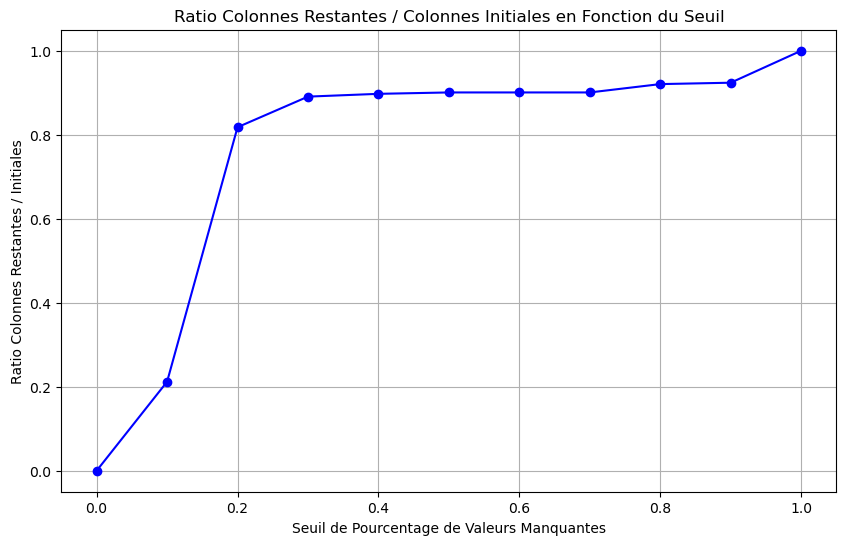

In [96]:
import pandas as pd
import matplotlib.pyplot as plt

def drop_columns_with_missing_values(dataframe, threshold):
    initial_columns = dataframe.shape[1]
    missing_percentage = dataframe.isnull().mean()
    columns_to_keep = missing_percentage[missing_percentage <= threshold].index
    print("nbre de colonnes à garder : ", len(columns_to_keep))
    print("nombre total de colonnes du dataframe : ", len(dataframe.columns))
    cleaned_dataframe = dataframe[columns_to_keep]
    final_columns = cleaned_dataframe.shape[1]
    ratio = final_columns / initial_columns
    return cleaned_dataframe, ratio


# print(drop_columns_with_missing_values(train_home_player,0.5))


# Générer les seuils et calculer les ratios
thresholds = [x / 10.0 for x in range(11)]  # 0.0 à 1.0 avec un pas de 0.1
ratios = [drop_columns_with_missing_values(train_home_player, threshold)[1] for threshold in thresholds]

# Tracer le graphique
plt.figure(figsize=(10, 6))
plt.plot(thresholds, ratios, marker='o', linestyle='-', color='b')
plt.title("Ratio Colonnes Restantes / Colonnes Initiales en Fonction du Seuil")
plt.xlabel("Seuil de Pourcentage de Valeurs Manquantes")
plt.ylabel("Ratio Colonnes Restantes / Initiales")
plt.grid(True)
plt.show()


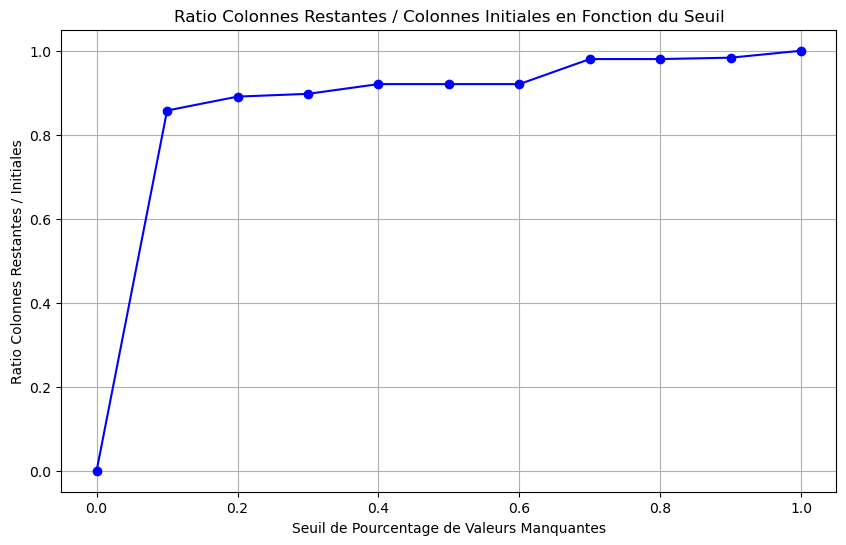

In [45]:
#Pour test home

import pandas as pd
import matplotlib.pyplot as plt

def drop_columns_with_missing_values(dataframe, threshold):
    initial_columns = dataframe.shape[1]
    missing_percentage = dataframe.isnull().mean()
    columns_to_keep = missing_percentage[missing_percentage <= threshold].index
    cleaned_dataframe = dataframe[columns_to_keep]
    final_columns = cleaned_dataframe.shape[1]
    ratio = final_columns / initial_columns
    return cleaned_dataframe, ratio


# Générer les seuils et calculer les ratios
thresholds = [x / 10.0 for x in range(11)]  # 0.0 à 1.0 avec un pas de 0.1
ratios = [drop_columns_with_missing_values(test_home_player, threshold)[1] for threshold in thresholds]

# Tracer le graphique
plt.figure(figsize=(10, 6))
plt.plot(thresholds, ratios, marker='o', linestyle='-', color='b')
plt.title("Ratio Colonnes Restantes / Colonnes Initiales en Fonction du Seuil")
plt.xlabel("Seuil de Pourcentage de Valeurs Manquantes")
plt.ylabel("Ratio Colonnes Restantes / Initiales")
plt.grid(True)
plt.show()


## On va donc prendre threshold = 0.3

In [46]:
threshold = 0.3

train_home_player = drop_columns_with_missing_values(train_home_player, threshold)[0]
train_away_player = drop_columns_with_missing_values(train_away_player, threshold)[0]
test_home_player = drop_columns_with_missing_values(test_home_player, threshold)[0]
test_away_player = drop_columns_with_missing_values(test_away_player, threshold)[0]




## Verifier que les colonnes sont les memes 

In [48]:
# Vérifier si les colonnes correspondent pour train_home et test_home
home_columns_match = set(train_home_player.columns) == set(test_home_player.columns)
print(f"Les colonnes de train_home_player et test_home_player correspondent : {home_columns_match}")

# Vérifier si les colonnes correspondent pour train_away et test_away
away_columns_match = set(train_away_player.columns) == set(test_away_player.columns)
print(f"Les colonnes de train_away_player et test_away_player correspondent : {away_columns_match}")

# Afficher les différences si elles existent
if not home_columns_match:
    print("Différences dans les colonnes (train_home vs test_home) :")
    print("Colonnes dans train_home_player mais pas dans test_home_player :",
          set(train_home_player.columns) - set(test_home_player.columns))
    print("Colonnes dans test_home_player mais pas dans train_home_player :",
          set(test_home_player.columns) - set(train_home_player.columns))

if not away_columns_match:
    print("Différences dans les colonnes (train_away vs test_away) :")
    print("Colonnes dans train_away_player mais pas dans test_away_player :",
          set(train_away_player.columns) - set(test_away_player.columns))
    print("Colonnes dans test_away_player mais pas dans train_away_player :",
          set(test_away_player.columns) - set(train_away_player.columns))
    
    


Les colonnes de train_home_player et test_home_player correspondent : True
Les colonnes de train_away_player et test_away_player correspondent : True


In [47]:
# Vérifier si les colonnes correspondent pour train_home et test_home
home_columns_match = set(train_home_player.columns) == set(test_home_player.columns)
print(f"Les colonnes de train_home_player et test_home_player correspondent : {home_columns_match}")

if not home_columns_match:
    # Identifier les colonnes communes
    common_home_columns = list(set(train_home_player.columns).intersection(set(test_home_player.columns)))
    # Aligner les colonnes
    train_home_player = train_home_player[common_home_columns]
    test_home_player = test_home_player[common_home_columns]
    print("Colonnes alignées pour train_home_player et test_home_player.")

# Vérifier si les colonnes correspondent pour train_away et test_away
away_columns_match = set(train_away_player.columns) == set(test_away_player.columns)
print(f"Les colonnes de train_away_player et test_away_player correspondent : {away_columns_match}")

if not away_columns_match:
    # Identifier les colonnes communes
    common_away_columns = list(set(train_away_player.columns).intersection(set(test_away_player.columns)))
    # Aligner les colonnes
    train_away_player = train_away_player[common_away_columns]
    test_away_player = test_away_player[common_away_columns]
    print("Colonnes alignées pour train_away_player et test_away_player.")


Les colonnes de train_home_player et test_home_player correspondent : False
Colonnes alignées pour train_home_player et test_home_player.
Les colonnes de train_away_player et test_away_player correspondent : False
Colonnes alignées pour train_away_player et test_away_player.


In [49]:
import pandas as pd

def aggregate_and_merge(team_stats, player_stats, id_column="ID"):
    """
    Agrège les statistiques des joueurs par ID et les fusionne avec les statistiques des équipes.
    
    Arguments :
    - team_stats (DataFrame) : Dataset contenant les statistiques des équipes (ex. train_data).
    - player_stats (DataFrame) : Dataset contenant les statistiques des joueurs (ex. train_home_player ou train_away_player).
    - id_column (str) : Nom de la colonne commune pour la jointure (par défaut "ID").
    
    Retourne :
    - DataFrame : Dataset fusionné avec une ligne par ID.
    """
    # Sélectionner automatiquement les colonnes numériques (exclure POSITION ou autres non-numériques)
    numeric_columns = player_stats.select_dtypes(include="number").columns.tolist()
    
    # Définir les fonctions d'agrégation (moyenne, somme, max, min)
    aggregations = {col: ["mean", "sum"] for col in numeric_columns}
    
    # Agréger les statistiques des joueurs par 'ID'
    aggregated_player_stats = player_stats.groupby(id_column).agg(aggregations).reset_index()
    
    # Aplatir les colonnes multi-index
    aggregated_player_stats.columns = [
        "_".join(col).strip("_") if isinstance(col, tuple) else col for col in aggregated_player_stats.columns
    ]
    
    # Fusionner avec les statistiques des équipes sur 'ID'
    final_data = pd.merge(team_stats, aggregated_player_stats, on=id_column, how="left")
    
    return final_data

fin = aggregate_and_merge(train_data,train_home_player)

# # print(fin.columns)
# fin.head

In [50]:
train_data = aggregate_and_merge(train_data,train_home_player)
train_data = aggregate_and_merge(train_data,train_away_player)

print("end train data")

test_data = aggregate_and_merge(test_data,test_home_player)
test_data = aggregate_and_merge(test_data,test_away_player)

print("end test data ")



end train data
end test data 


In [35]:
train_data.head()

,ID,HOME_TEAM_SHOTS_TOTAL_season_sum,HOME_TEAM_SHOTS_INSIDEBOX_season_sum,HOME_TEAM_SHOTS_OFF_TARGET_season_sum,HOME_TEAM_SHOTS_ON_TARGET_season_sum,HOME_TEAM_SHOTS_OUTSIDEBOX_season_sum,HOME_TEAM_PASSES_season_sum,HOME_TEAM_SUCCESSFUL_PASSES_season_sum,HOME_TEAM_SAVES_season_sum,HOME_TEAM_CORNERS_season_sum,...,AWAY_PLAYER_GOALS_CONCEDED_5_last_match_average_mean,AWAY_PLAYER_GOALS_CONCEDED_5_last_match_average_sum,AWAY_PLAYER_TOTAL_DUELS_season_std_mean,AWAY_PLAYER_TOTAL_DUELS_season_std_sum,AWAY_PLAYER_CLEARANCES_season_sum_mean,AWAY_PLAYER_CLEARANCES_season_sum_sum,AWAY_PLAYER_PENALTIES_SCORED_season_sum_mean,AWAY_PLAYER_PENALTIES_SCORED_season_sum_sum,AWAY_PLAYER_MINUTES_PLAYED_5_last_match_std_mean,AWAY_PLAYER_MINUTES_PLAYED_5_last_match_std_sum
0,0,3.0,2.0,5.0,2.0,1.0,2.0,2.0,5.0,3.0,...,38.611111,695.0,31.411765,534.0,11.277778,203.0,5.500000,99.0,24.941176,424.0
1,1,6.0,8.0,3.0,6.0,5.0,8.0,7.0,10.0,6.0,...,39.777778,716.0,34.500000,621.0,13.833333,249.0,1.833333,33.0,55.611111,1001.0
2,2,4.0,2.0,5.0,2.0,8.0,1.0,1.0,2.0,2.0,...,43.391304,998.0,37.954545,835.0,12.086957,278.0,1.304348,30.0,32.409091,713.0
3,3,7.0,5.0,5.0,6.0,6.0,9.0,9.0,2.0,2.0,...,30.705882,522.0,30.250000,484.0,15.000000,255.0,0.000000,0.0,21.375000,342.0
4,4,3.0,3.0,2.0,3.0,4.0,4.0,3.0,4.0,4.0,...,26.888889,484.0,33.500000,603.0,18.833333,339.0,5.555556,100.0,26.777778,482.0


In [52]:
print(len(train_data.columns))
print(len(test_data.columns))

print(len(train_home_team_statistics_df.columns))
print(len(train_home_player_statistics_df.columns))

1357
1357
142
306


## Étape 1 : Heatmaps pour les groupes de colonnes spécifiques


Étape 4 : Heatmaps spécifiques


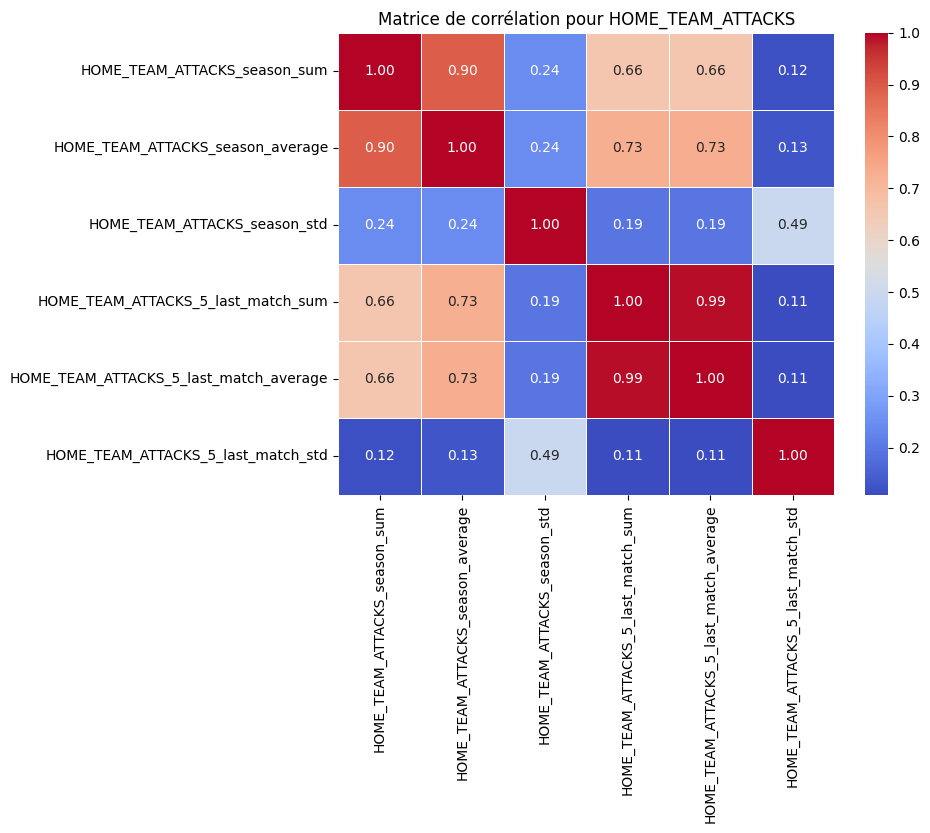

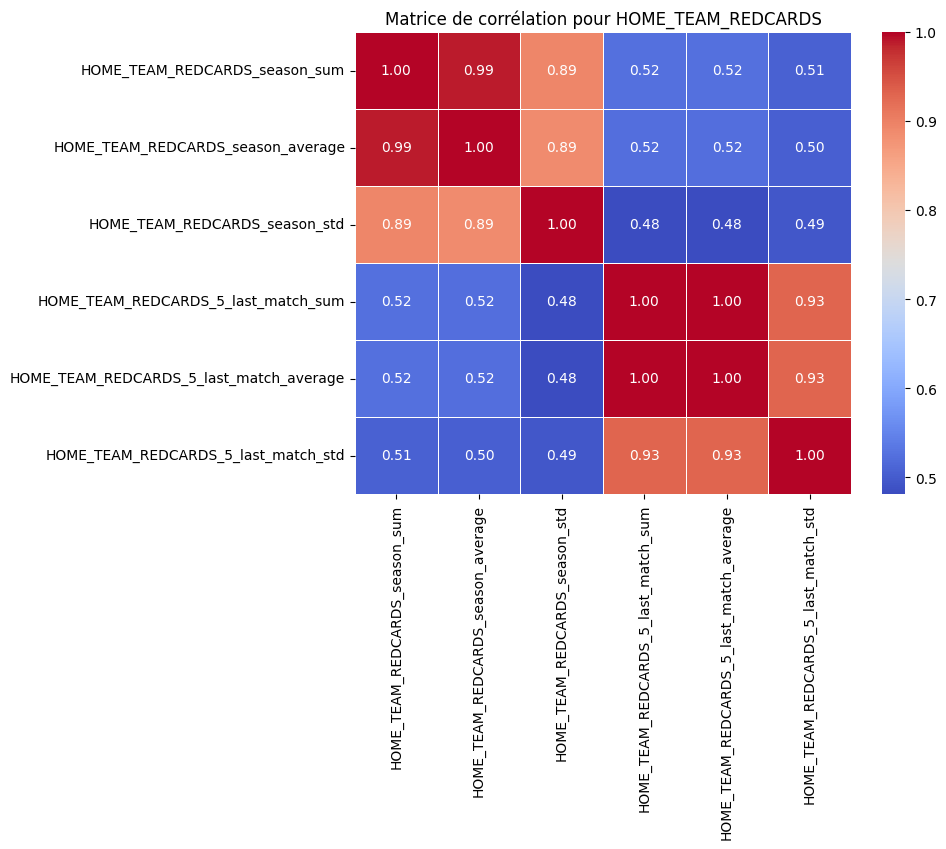

In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt



def plot_correlation_heatmap(df, filter_keyword, title):
    """
    Trace une heatmap pour les colonnes contenant un mot-clé spécifique.

    Arguments :
    - df : DataFrame à traiter
    - filter_keyword : Mot-clé pour filtrer les colonnes (par exemple, "HOME_TEAM_ATTACKS")
    - title : Titre du graphique
    """
    filtered_columns = [col for col in df.columns if filter_keyword in col]
    filtered_corr_matrix = df[filtered_columns].corr()

    plt.figure(figsize=(8, 6))
    sns.heatmap(filtered_corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
    plt.title(title)
    plt.show()

print("\nÉtape 4 : Heatmaps spécifiques")
plot_correlation_heatmap(train_data, filter_keyword="HOME_TEAM_ATTACKS", title="Matrice de corrélation pour HOME_TEAM_ATTACKS")
plot_correlation_heatmap(train_data, filter_keyword="HOME_TEAM_REDCARDS", title="Matrice de corrélation pour HOME_TEAM_REDCARDS")


## Etape 2 : SUppression des colonnes trop corrélées (corr > 0.8)

In [40]:
## Méthode 1 

In [ ]:

def drop_highly_correlated_features(df, threshold=0.8, df_name="Dataset"):
    """
    Supprime les colonnes avec une corrélation supérieure au seuil donné.

    Arguments :
    - df : DataFrame à traiter
    - threshold : Seuil de corrélation
    - df_name : Nom du DataFrame (optionnel, pour affichage)

    Retourne :
    - Le DataFrame avec les colonnes fortement corrélées supprimées
    """
    correlation_matrix = df.corr()
    upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))

    to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > threshold)]
    print(f"\n=== {df_name} ===")
    print(f"Colonnes supprimées en raison d'une forte corrélation : {to_drop}")
    print(len(to_drop))

    return df.drop(columns=to_drop)




print("\nÉtape 2 : Suppression des colonnes fortement corrélées")
train_data = drop_highly_correlated_features(train_data, threshold=0.8, df_name="Train Data")
test_data = drop_highly_correlated_features(test_data, threshold=0.8, df_name="Test Data")


In [41]:
##Méthode 2 avec suppression des memes colonnes à gauche et à droite

In [ ]:
def drop_highly_correlated_features(df, threshold=0.8, df_name="Dataset"):
    """
    Supprime les colonnes avec une corrélation supérieure au seuil donné.

    Arguments :
    - df : DataFrame à traiter
    - threshold : Seuil de corrélation
    - df_name : Nom du DataFrame (optionnel, pour affichage)

    Retourne :
    - Le DataFrame avec les colonnes fortement corrélées supprimées
    - La liste des colonnes supprimées
    """
    correlation_matrix = df.corr()
    upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))

    to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > threshold)]
    print(f"\n=== {df_name} ===")
    print(f"Colonnes supprimées en raison d'une forte corrélation : {to_drop}")
    print(f"Nombre de colonnes supprimées : {len(to_drop)}")

    return df.drop(columns=to_drop), to_drop


print("\nÉtape 2 : Suppression des colonnes fortement corrélées dans Train et Test")

# Supprimer les colonnes fortement corrélées du DataFrame d'entraînement
train_data, removed_columns = drop_highly_correlated_features(train_data, threshold=0.8, df_name="Train Data")

# Supprimer les mêmes colonnes du DataFrame de test
test_data = test_data.drop(columns=removed_columns, errors='ignore')  # `errors='ignore'` pour éviter des erreurs si certaines colonnes sont absentes


In [54]:
print(len(train_data.columns))
print(len(test_data.columns))

print(len(train_home_team_statistics_df.columns))
print(len(train_home_player_statistics_df.columns))

470
470
142
306


## Remplacemeent des valeurs manquantes et rajout d'une variable binaire si il manque une valeur

In [59]:
def add_missing_indicators_and_fill(train_df, test_df, df_name="Dataset"):
    """
    Traite les valeurs manquantes en ajoutant des indicateurs binaires dans les deux jeux de données.
    Remplit les valeurs manquantes dans le jeu d'entraînement avec la médiane du train
    et dans le jeu de test avec la médiane du test.

    Arguments :
    - train_df : DataFrame d'entraînement
    - test_df : DataFrame de test
    - df_name : Nom du DataFrame pour affichage (optionnel)

    Retourne :
    - Le DataFrame d'entraînement traité
    - Le DataFrame de test traité
    """
    # Identifier les colonnes avec des valeurs manquantes dans le jeu d'entraînement
    missing_cols = train_df.columns[train_df.isnull().any()]
    print(f"\n=== {df_name} ===")
    print(f"Colonnes avec données manquantes dans le train : {len(missing_cols)}")
    print(missing_cols)

    # Ajouter des colonnes binaires pour les colonnes manquantes dans les deux jeux
    for col in missing_cols:
        # Ajouter une colonne binaire dans le train
        train_df[f"{col}_missing"] = train_df[col].isnull().astype(int)
        # Ajouter une colonne binaire correspondante dans le test
        test_df[f"{col}_missing"] = test_df[col].isnull().astype(int)

    # Remplacer les valeurs manquantes dans le train par la médiane du train
    for col in missing_cols:
        train_median = train_df[col].median()
        train_df[col].fillna(train_median, inplace=True)

    # Identifier les colonnes avec des valeurs manquantes dans le test (juste pour le log)
    test_missing_cols = test_df.columns[test_df.isnull().any()]
    print(f"Colonnes avec données manquantes dans le test : {len(test_missing_cols)}")
    print(test_missing_cols)

    # Remplacer les valeurs manquantes dans le test par la médiane du test
    for col in test_missing_cols:
        test_median = test_df[col].median()
        test_df[col].fillna(test_median, inplace=True)

    # Vérification des données manquantes après traitement
    total_missing_train = train_df.isnull().sum().sum()
    total_missing_test = test_df.isnull().sum().sum()
    print(f"Valeurs manquantes restantes après traitement dans le train : {total_missing_train}")
    print(f"Valeurs manquantes restantes après traitement dans le test : {total_missing_test}")

    return train_df, test_df

print("\nÉtape 3 : Traitement des valeurs manquantes dans Train et Test")

# Appliquer le traitement des valeurs manquantes
train_data, test_data = add_missing_indicators_and_fill(train_data, test_data, df_name="Train/Test Data")




Étape 3 : Traitement des valeurs manquantes dans Train et Test

=== Train/Test Data ===
Colonnes avec données manquantes dans le train : 0
Index([], dtype='object')
Colonnes avec données manquantes dans le test : 32
Index(['HOME_TEAM_SHOTS_OFF_TARGET_season_sum',
       'HOME_TEAM_SHOTS_ON_TARGET_season_std', 'HOME_TEAM_CORNERS_season_std',
       'HOME_TEAM_ATTACKS_season_std',
       'HOME_TEAM_DANGEROUS_ATTACKS_season_std',
       'HOME_TEAM_SHOTS_OFF_TARGET_5_last_match_sum',
       'HOME_TEAM_ATTACKS_5_last_match_sum',
       'HOME_TEAM_DANGEROUS_ATTACKS_5_last_match_sum',
       'HOME_TEAM_SHOTS_ON_TARGET_5_last_match_std',
       'HOME_TEAM_CORNERS_5_last_match_std',
       'HOME_TEAM_ATTACKS_5_last_match_std',
       'HOME_TEAM_DANGEROUS_ATTACKS_5_last_match_std',
       'AWAY_TEAM_SHOTS_OFF_TARGET_season_sum',
       'AWAY_TEAM_SHOTS_ON_TARGET_season_std', 'AWAY_TEAM_CORNERS_season_std',
       'AWAY_TEAM_ATTACKS_season_std',
       'AWAY_TEAM_DANGEROUS_ATTACKS_season_std',
 

In [60]:
print(len(train_data.columns))
print(len(test_data.columns))

print(len(train_home_team_statistics_df.columns))
print(len(train_home_player_statistics_df.columns))

855
855
142
306


In [61]:

X_train, X_test, y_train, y_test = model_selection.train_test_split(train_data, train_scores, train_size=0.8, random_state=42)
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X_train, y_train, train_size=0.8, random_state=42)


# On va maintenant appliquer XGboost en utilisant les hyperparametres trouvées avec l'autre note book, à savoir : 'learning_rate': 0.01, 'max_depth': 3

### Avec xgb.train

In [65]:

print(len(y_train))
print(len(X_train))

7873
7873


### Si l'on souhaite appliquer notre modèle avec victoire - nul - défaite, on doit utiliser les lignes de codes suivantes : sinon on utilise celle d'en dessous

In [ ]:
y_train = np.argmax(y_train.values, axis=1) #nécessaire pour correspondre au format de xgboost
y_valid = np.argmax(y_valid.values, axis=1)

#Cette méthode a des moins bons résultats qu'une classification binaire 

In [ ]:
y_train = y_train['AWAY_WINS']
y_valid = y_valid['AWAY_WINS']

print(y_train)
print(y_test)

In [88]:


params_1 = {
    'booster': 'gbtree', #Utilise des arbres de décision comme base (classic choice for many problems).
    'tree_method':'hist', #Utilise une approche basée sur des histogrammes pour accélérer l'entraînement, particulièrement efficace pour les grands ensembles de données.
    'max_depth': 3, #Contrôle la profondeur maximale des arbres.
    'learning_rate': 0.01,
    'objective': 'multi:softprob', #cela indique que le modèle doit effectuer une classification multi-classes et renvoyer les probabilités pour chaque classe.
    'num_class': 2, #On se contente juste de savoir qui gagne, sans prendre en compte les cas d'égalité pour le moment
    'eval_metric':'mlogloss'
    }



d_train = xgb.DMatrix(X_train, y_train) #X (features) : Données combinées des statistiques des équipes à domicile et à l'extérieur.
                                                            #y (labels) : Résultats des matchs codés comme 0 (victoire domicile), 1 (match nul), ou 2 (victoire extérieur).
d_valid = xgb.DMatrix(X_valid, y_valid)

num_round = 10000
evallist = [(d_train, 'train'), (d_valid, 'eval')]


bst = xgb.train(params_1, d_train, num_round, evallist, early_stopping_rounds=100)


[0]	train-mlogloss:0.69112	eval-mlogloss:0.69118
[1]	train-mlogloss:0.68914	eval-mlogloss:0.68923
[2]	train-mlogloss:0.68720	eval-mlogloss:0.68734
[3]	train-mlogloss:0.68529	eval-mlogloss:0.68548
[4]	train-mlogloss:0.68345	eval-mlogloss:0.68363
[5]	train-mlogloss:0.68162	eval-mlogloss:0.68184
[6]	train-mlogloss:0.67984	eval-mlogloss:0.68006
[7]	train-mlogloss:0.67807	eval-mlogloss:0.67834
[8]	train-mlogloss:0.67636	eval-mlogloss:0.67661
[9]	train-mlogloss:0.67466	eval-mlogloss:0.67497
[10]	train-mlogloss:0.67300	eval-mlogloss:0.67330
[11]	train-mlogloss:0.67136	eval-mlogloss:0.67172
[12]	train-mlogloss:0.66976	eval-mlogloss:0.67011
[13]	train-mlogloss:0.66820	eval-mlogloss:0.66857
[14]	train-mlogloss:0.66665	eval-mlogloss:0.66704
[15]	train-mlogloss:0.66512	eval-mlogloss:0.66549
[16]	train-mlogloss:0.66363	eval-mlogloss:0.66402
[17]	train-mlogloss:0.66215	eval-mlogloss:0.66251
[18]	train-mlogloss:0.66068	eval-mlogloss:0.66107
[19]	train-mlogloss:0.65925	eval-mlogloss:0.65962
[20]	train

## dernière valeur: 0.55552

In [87]:
target = train_scores.loc[X_test.index].copy()
# print(X_test)

X_test_xgb = xgb.DMatrix(X_test) 

predictions = bst.predict(X_test_xgb, iteration_range=(0, bst.best_iteration))
predictions = pd.DataFrame(predictions)

predictions[2] = 0
predictions.columns = [0,2,1]
predictions = (predictions.reindex(columns=[0,1,2]).rank(1,ascending=False)==1).astype(int).values
res = np.round(accuracy_score(predictions,target),4)

print(f"le résultat lorsqu'on prédit avec notre modèle et les joueurs + binaire : {res}")

le résultat lorsqu'on prédit avec notre modèle et les joueurs + binaire : 0.4762


## score : 0.4718

## Submission

In [85]:

test_home_bis = pd.read_csv('test_home_team_statistics_df.csv', index_col=0)
test_away_bis = pd.read_csv('test_away_team_statistics_df.csv', index_col=0)


# print(test_home_bis.index)


# def preprocess_test_data(test_data, train_data):
#     # Imputer avec les moyennes de train_data
#     mean_values = train_data.mean()
#     test_data_filled = test_data.fillna(mean_values)

#     # # Aligner les colonnes avec celles de train_data
#     test_data_aligned = test_data_filled[train_data.columns]

#     return test_data_aligned

# # Préparer test_data
# test_data_prepared = preprocess_test_data(test_data, train_data)




X_bench = xgb.DMatrix(test_data)

predictions = bst.predict(X_bench, iteration_range=(0, bst.best_iteration))
predictions = pd.DataFrame(predictions)



predictions[2] = 0
predictions.columns = [0,2,1]
predictions = (predictions.reindex(columns=[0,1,2]).rank(1,ascending=False)==1).astype(int)

predictions.columns = ['HOME_WINS', 'DRAW', 'AWAY_WINS']
predictions.index = test_home_bis.index

print(predictions.index)

submission = predictions.reset_index()

print(submission.reset_index())

submission.to_csv('./benchmark3_submission_test_binaire_player.csv', index=False)


Index([12303, 12304, 12305, 12306, 12307, 12308, 12309, 12310, 12311, 12312,
       ...
       37661, 37662, 37663, 37664, 37665, 37666, 37667, 37668, 37669, 37670],
      dtype='int64', name='ID', length=25368)
       index     ID  HOME_WINS  DRAW  AWAY_WINS
0          0  12303          1     0          0
1          1  12304          1     0          0
2          2  12305          1     0          0
3          3  12306          1     0          0
4          4  12307          1     0          0
...      ...    ...        ...   ...        ...
25363  25363  37666          1     0          0
25364  25364  37667          1     0          0
25365  25365  37668          1     0          0
25366  25366  37669          1     0          0
25367  25367  37670          1     0          0

[25368 rows x 5 columns]


### XGBoost presentation
The model we used is Extreme Gradient Boosting, which is a popular and efficient gradient boosting algorithm. We used the XGBClassifier class from the xgboost package.

XGBoost is a powerful implementation of the gradient boosting algorithm, which is a machine learning technique for regression and classification problems, which produces a prediction model in the form of an ensemble of weak prediction models, typically decision trees. It builds the model in a stage-wise fashion like other boosting methods do, and it generalizes them by allowing optimization of an arbitrary differentiable loss function.

The package already implements the two following ensemble methods, so that we did not have to implement them ourselves:

Bagging: It is a technique that aims to reduce the variance of an estimate. It is a special case of the model averaging approach. Bagging is short for bootstrap aggregating. It works by taking many bootstrapped samples from the training data and training a separate model for each sample. The final prediction is then made by averaging the predictions of all models.

Boosting: It is a technique that aims to reduce the bias of an estimate. Boosting works by training a sequence of models, each of which learns to fix the prediction errors of the previous model in the sequence. The final prediction is then made by averaging the predictions of all models.



# Cross validation

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss, accuracy_score
from xgboost import XGBClassifier

# Charger les données
test_home = pd.read_csv('./Test_Data/test_home_team_statistics_df.csv', index_col=0)
test_away = pd.read_csv('./Test_Data/test_away_team_statistics_df.csv', index_col=0)

test_home.columns = 'HOME_' + test_home.columns
test_away.columns = 'AWAY_' + test_away.columns

test_data = pd.concat([test_home, test_away], join='inner', axis=1)

# Fonction pour prétraiter test_data
def preprocess_test_data(test_data, train_data):
    # Imputer avec les moyennes de train_data
    mean_values = train_data.mean()
    test_data_filled = test_data.fillna(mean_values)

    # Ajouter les colonnes binaires pour les données manquantes
    missing_columns = train_data.columns[train_data.isnull().any()]
    for col in missing_columns:
        if col not in test_data.columns:
            test_data[col] = 0
        test_data_filled[f"{col}_missing"] = test_data[col].isnull().astype(int)

    # Ajouter toutes les colonnes manquantes dans test_data
    for col in train_data.columns:
        if col not in test_data_filled.columns:
            test_data_filled[col] = 0

    # Aligner les colonnes avec celles de train_data
    test_data_aligned = test_data_filled[train_data.columns]

    return test_data_aligned

# Paramètres du modèle
params = {
    'booster': 'gbtree',
    'tree_method': 'hist',
    'max_depth': 3,
    'learning_rate': 0.01,
    'objective': 'multi:softprob',  # Pour classification multi-classes
    'num_class': 2,  # Nombre de classes
    'eval_metric': 'mlogloss',
    'use_label_encoder': False
}

# Cross-validation avec StratifiedKFold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
log_loss_scores = []
accuracy_scores = []

# Initialisation du modèle
xgb_model = XGBClassifier(**params, n_estimators=100)

# Boucle de cross-validation
for fold, (train_index, valid_index) in enumerate(kf.split(X_train, y_train)):
    print(f"--- Fold {fold + 1} ---")
    
    # Séparer les données en train et validation pour ce fold
    X_train_fold, X_valid_fold = X_train.iloc[train_index], X_train.iloc[valid_index]
    y_train_fold, y_valid_fold = y_train.iloc[train_index], y_train.iloc[valid_index]
    
    # Entraîner le modèle sur ce fold
    xgb_model.fit(
        X_train_fold, y_train_fold,
        eval_set=[(X_train_fold, y_train_fold), (X_valid_fold, y_valid_fold)],
        early_stopping_rounds=100,
        verbose=False
    )
    
    # Faire des prédictions sur le fold de validation
    y_valid_pred_proba = xgb_model.predict_proba(X_valid_fold)
    y_valid_pred = np.argmax(y_valid_pred_proba, axis=1)
    
    # Calculer les métriques
    log_loss_fold = log_loss(y_valid_fold, y_valid_pred_proba)
    accuracy_fold = accuracy_score(y_valid_fold, y_valid_pred)
    
    log_loss_scores.append(log_loss_fold)
    accuracy_scores.append(accuracy_fold)
    
    print(f"Log Loss pour ce fold : {log_loss_fold:.4f}")
    print(f"Accuracy pour ce fold : {accuracy_fold:.4f}")

# Résultats moyens de la cross-validation
print("\n--- Résultats moyens sur les folds ---")
print(f"Log Loss moyen : {np.mean(log_loss_scores):.4f} ± {np.std(log_loss_scores):.4f}")
print(f"Accuracy moyenne : {np.mean(accuracy_scores):.4f} ± {np.std(accuracy_scores):.4f}")

# Prétraiter test_data pour faire des prédictions finales
test_data_prepared = preprocess_test_data(test_data, train_data)

# Faire des prédictions finales sur test_data
X_bench = xgb.DMatrix(test_data_prepared)
final_predictions_proba = xgb_model.predict_proba(test_data_prepared)
final_predictions = np.argmax(final_predictions_proba, axis=1)

# Générer le fichier de soumission
predictions = pd.DataFrame(final_predictions_proba, columns=["HOME_WINS", "AWAY_WINS"])




predictions[2] = 0
predictions.columns = [0,2,1]
predictions = (predictions.reindex(columns=[0,1,2]).rank(1,ascending=False)==1).astype(int)

predictions.columns = ['HOME_WINS', 'DRAW', 'AWAY_WINS']
predictions.index = test_data.index
submission = predictions.reset_index()
submission.to_csv('./benchmark2_submission_crossvalidation.csv', index=False)


--- Fold 1 ---
Log Loss pour ce fold : 0.6035
Accuracy pour ce fold : 0.6997
--- Fold 2 ---
Log Loss pour ce fold : 0.6012
Accuracy pour ce fold : 0.7092
--- Fold 3 ---
Log Loss pour ce fold : 0.6059
Accuracy pour ce fold : 0.7016
--- Fold 4 ---
Log Loss pour ce fold : 0.6035
Accuracy pour ce fold : 0.7014
--- Fold 5 ---
Log Loss pour ce fold : 0.6052
Accuracy pour ce fold : 0.7065

--- Résultats moyens sur les folds ---
Log Loss moyen : 0.6039 ± 0.0016
Accuracy moyenne : 0.7037 ± 0.0036


# On va essayer de rajouter des variables correspondants au winrate et à l'elo 

In [16]:

train_home_team_statistics_df = pd.read_csv('./Train_Data/train_home_team_statistics_df.csv', index_col=0)
train_away_team_statistics_df = pd.read_csv('./Train_Data/train_away_team_statistics_df.csv', index_col=0)

train_scores = pd.read_csv('./Y_train.csv', index_col=0)


train_home = train_home_team_statistics_df.iloc[:,1:] #On enlève le nom de l'équipe et de la compétition
train_away = train_away_team_statistics_df.iloc[:,1:]
train_home.columns = 'HOME_' + train_home.columns #on rajoute aux noms des variables home et away pour pouvoir ensuite concaténer
train_away.columns = 'AWAY_' + train_away.columns
train_data =  pd.concat([train_home,train_away],join='inner',axis=1) #on effectue une jointure pour obtenir qu'une seule table avec les infos de away et de home 
print(f"nombre de ligne de train_data: {train_data.shape[0]}")
print(f"nombre de ligne de train_scores actuellement : {train_scores.shape[0]}")
train_scores = train_scores.loc[train_data.index] #alligne les données entre les 2 structures
print(f"nombre de ligne de train_scores après allignement : {train_scores.shape[0]}")
train_data = train_data.replace({np.inf:np.nan,-np.inf:np.nan}) # Remplacement des valeurs infinies par NaN

print("test")
print(train_data)





nombre de ligne de train_data: 12303
nombre de ligne de train_scores actuellement : 12303
nombre de ligne de train_scores après allignement : 12303
test
                HOME_TEAM_NAME  HOME_TEAM_SHOTS_TOTAL_season_sum  \
ID                                                                 
0                     Toulouse                               3.0   
1                        Brest                               6.0   
2                    Sampdoria                               4.0   
3                Coventry City                               7.0   
4      Wolverhampton Wanderers                               3.0   
...                        ...                               ...   
12298          Southend United                               4.0   
12299                 Boavista                               4.0   
12300               Schalke 04                               4.0   
12301           Fleetwood Town                               2.0   
12302                 Valencia 

In [43]:
import pandas as pd

def calcul_victory(data, score):
    team_victories = {}  # Nombre de victoires
    team_total_game = {}  # Total de matchs joués
    
    # Parcours des matchs à domicile
    for team, home_win in zip(data["HOME_TEAM_NAME"], score["HOME_WINS"]):
        team_total_game[team] = team_total_game.get(team, 0) + 1
        if home_win == 1:
            team_victories[team] = team_victories.get(team, 0) + 1

    # Parcours des matchs à l'extérieur
    for team, away_win in zip(data["AWAY_TEAM_NAME"], score["AWAY_WINS"]):
        team_total_game[team] = team_total_game.get(team, 0) + 1
        if away_win == 1:
            team_victories[team] = team_victories.get(team, 0) + 1

    return team_victories, team_total_game

def calcul_draw(data, score):
    team_draws = {}  # Nombre de matchs nuls

    # Parcours des matchs à domicile
    for team, draw in zip(data["HOME_TEAM_NAME"], score["DRAW"]):
        if draw == 1:
            team_draws[team] = team_draws.get(team, 0) + 1

    # Parcours des matchs à l'extérieur
    for team, draw in zip(data["AWAY_TEAM_NAME"], score["DRAW"]):
        if draw == 1:
            team_draws[team] = team_draws.get(team, 0) + 1

    return team_draws

def calcul_win_rate(victories, draws, totals):
    """
    Calcule le taux de victoire avec 0.5 * matchs nuls.
    """
    win_rates = {}
    for team in totals:
        win = victories.get(team, 0)
        draw = draws.get(team, 0)
        total = totals[team]
        win_rates[team] = (win + 0.5 * draw) / total if total > 0 else 0
    return win_rates

def winrate(data, score):
    # Calcul des victoires, matchs totaux et nuls
    victories, total_games = calcul_victory(data, score)
    draws = calcul_draw(data, score)
    
    # Calcul des taux de victoire
    win_rates = calcul_win_rate(victories, draws, total_games)

    # Ajout de la colonne `HOME_winrate` pour chaque ligne
    data["HOME_winrate"] = data["HOME_TEAM_NAME"].map(win_rates)
    data["AWAY_winrate"] = data["AWAY_TEAM_NAME"].map(win_rates)

    return data

# Exemple d'utilisation avec vos DataFrames `train_data` et `train_scores`
train_data = winrate(train_data, train_scores)


In [46]:
print(train_data["AWAY_TEAM_NAME"])

ID
0        Olympique Marseille
1                   Red Star
2                    Bologna
3           Bolton Wanderers
4             Leicester City
                ...         
12298     Accrington Stanley
12299               Marítimo
12300             RB Leipzig
12301       Doncaster Rovers
12302           FC Barcelona
Name: AWAY_TEAM_NAME, Length: 12303, dtype: object


In [47]:
train_data = train_data.drop(columns=["AWAY_TEAM_NAME", "HOME_TEAM_NAME"])

train_data = drop_highly_correlated_features(train_data, threshold=0.8, df_name="Train Data")
test_data = drop_highly_correlated_features(test_data, threshold=0.8, df_name="Test Data")
train_data = add_missing_indicators_and_fill(train_data, df_name="Train Data")
test_data = add_missing_indicators_and_fill(test_data, df_name="Test Data")



=== Train Data ===
Colonnes supprimées en raison d'une forte corrélation : ['HOME_TEAM_SHOTS_INSIDEBOX_season_sum', 'HOME_TEAM_SUCCESSFUL_PASSES_season_sum', 'HOME_TEAM_SHOTS_TOTAL_season_average', 'HOME_TEAM_SHOTS_INSIDEBOX_season_average', 'HOME_TEAM_SHOTS_OFF_TARGET_season_average', 'HOME_TEAM_SHOTS_ON_TARGET_season_average', 'HOME_TEAM_SHOTS_OUTSIDEBOX_season_average', 'HOME_TEAM_PASSES_season_average', 'HOME_TEAM_SUCCESSFUL_PASSES_season_average', 'HOME_TEAM_SUCCESSFUL_PASSES_PERCENTAGE_season_average', 'HOME_TEAM_SAVES_season_average', 'HOME_TEAM_CORNERS_season_average', 'HOME_TEAM_BALL_POSSESSION_season_average', 'HOME_TEAM_FOULS_season_average', 'HOME_TEAM_YELLOWCARDS_season_average', 'HOME_TEAM_REDCARDS_season_average', 'HOME_TEAM_OFFSIDES_season_average', 'HOME_TEAM_ATTACKS_season_average', 'HOME_TEAM_PENALTIES_season_average', 'HOME_TEAM_SUBSTITUTIONS_season_average', 'HOME_TEAM_DANGEROUS_ATTACKS_season_average', 'HOME_TEAM_INJURIES_season_average', 'HOME_TEAM_GOALS_season_

In [48]:

X_train, X_test, y_train, y_test = model_selection.train_test_split(train_data, train_scores, train_size=0.8, random_state=42)
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X_train, y_train, train_size=0.8, random_state=42)


y_train = y_train['AWAY_WINS']
y_valid = y_valid['AWAY_WINS']



params_1 = {
    'booster': 'gbtree', #Utilise des arbres de décision comme base (classic choice for many problems).
    'tree_method':'hist', #Utilise une approche basée sur des histogrammes pour accélérer l'entraînement, particulièrement efficace pour les grands ensembles de données.
    'max_depth': 3, #Contrôle la profondeur maximale des arbres.
    'learning_rate': 0.01,
    'objective': 'multi:softprob', #cela indique que le modèle doit effectuer une classification multi-classes et renvoyer les probabilités pour chaque classe.
    'num_class': 2, #On se contente juste de savoir qui gagne, sans prendre en compte les cas d'égalité pour le moment
    'eval_metric':'mlogloss'
    }



d_train = xgb.DMatrix(X_train, y_train) #X (features) : Données combinées des statistiques des équipes à domicile et à l'extérieur.
                                                            #y (labels) : Résultats des matchs codés comme 0 (victoire domicile), 1 (match nul), ou 2 (victoire extérieur).
d_valid = xgb.DMatrix(X_valid, y_valid)

num_round = 10000
evallist = [(d_train, 'train'), (d_valid, 'eval')]


bst = xgb.train(params_1, d_train, num_round, evallist, early_stopping_rounds=100)

target = train_scores.loc[X_test.index].copy()

X_test_xgb = xgb.DMatrix(X_test) 

predictions = bst.predict(X_test_xgb, iteration_range=(0, bst.best_iteration))
predictions = pd.DataFrame(predictions)

predictions[2] = 0
predictions.columns = [0,2,1]
predictions = (predictions.reindex(columns=[0,1,2]).rank(1,ascending=False)==1).astype(int).values
res = np.round(accuracy_score(predictions,target),4)

print(f"le résultat lorsqu'on prédit avec notre modèle 'basique' + néttoyage des données + rajout de la nouvelle métrique winrate, entrainé : {res}")

[0]	train-mlogloss:0.69077	eval-mlogloss:0.69074
[1]	train-mlogloss:0.68845	eval-mlogloss:0.68838
[2]	train-mlogloss:0.68616	eval-mlogloss:0.68604
[3]	train-mlogloss:0.68391	eval-mlogloss:0.68375
[4]	train-mlogloss:0.68172	eval-mlogloss:0.68152
[5]	train-mlogloss:0.67956	eval-mlogloss:0.67932
[6]	train-mlogloss:0.67744	eval-mlogloss:0.67714
[7]	train-mlogloss:0.67537	eval-mlogloss:0.67502
[8]	train-mlogloss:0.67333	eval-mlogloss:0.67292
[9]	train-mlogloss:0.67133	eval-mlogloss:0.67087
[10]	train-mlogloss:0.66938	eval-mlogloss:0.66885
[11]	train-mlogloss:0.66745	eval-mlogloss:0.66689
[12]	train-mlogloss:0.66557	eval-mlogloss:0.66494
[13]	train-mlogloss:0.66372	eval-mlogloss:0.66304
[14]	train-mlogloss:0.66191	eval-mlogloss:0.66116
[15]	train-mlogloss:0.66012	eval-mlogloss:0.65933
[16]	train-mlogloss:0.65837	eval-mlogloss:0.65753
[17]	train-mlogloss:0.65666	eval-mlogloss:0.65575
[18]	train-mlogloss:0.65497	eval-mlogloss:0.65403
[19]	train-mlogloss:0.65332	eval-mlogloss:0.65231
[20]	train

## Ce modèle semble plutot interessant cependant nous rencontrons le problème suivant : 

Pour prédire victoire ou défaite sur notre dataset de test, nous ne conaissons pas le nom de l'équipe ou ne nous pouvons pas l'identifier donc nous ne pouvons pas appliquer notre winrate.

Nous devons donc repenser notre variable win rate autrement, nous allons utilisé directement les variables présentes dans les données :

(On aurait du s'en douter plus tot ...)

In [54]:

train_home_team_statistics_df = pd.read_csv('./Train_Data/train_home_team_statistics_df.csv', index_col=0)
train_away_team_statistics_df = pd.read_csv('./Train_Data/train_away_team_statistics_df.csv', index_col=0)
train_scores = pd.read_csv('./Y_train.csv', index_col=0)
train_home = train_home_team_statistics_df.iloc[:,2:] #On enlève le nom de l'équipe et de la compétition
train_away = train_away_team_statistics_df.iloc[:,2:]
train_home.columns = 'HOME_' + train_home.columns #on rajoute aux noms des variables home et away pour pouvoir ensuite concaténer
train_away.columns = 'AWAY_' + train_away.columns
train_data =  pd.concat([train_home,train_away],join='inner',axis=1) #on effectue une jointure pour obtenir qu'une seule table avec les infos de away et de home 
print(f"nombre de ligne de train_data: {train_data.shape[0]}")
print(f"nombre de ligne de train_scores actuellement : {train_scores.shape[0]}")
train_scores = train_scores.loc[train_data.index] #alligne les données entre les 2 structures
print(f"nombre de ligne de train_scores après allignement : {train_scores.shape[0]}")
train_data = train_data.replace({np.inf:np.nan,-np.inf:np.nan}) # Remplacement des valeurs infinies par NaN



test_home = pd.read_csv('./Test_Data/test_home_team_statistics_df.csv', index_col=0)
test_away = pd.read_csv('./Test_Data/test_away_team_statistics_df.csv', index_col=0)

test_home.columns = 'HOME_' + test_home.columns
test_away.columns = 'AWAY_' + test_away.columns

test_data =  pd.concat([test_home,test_away],join='inner',axis=1)




# X_train, X_test, y_train, y_test = model_selection.train_test_split(train_data, train_scores, train_size=0.8, random_state=42)
# X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X_train, y_train, train_size=0.8, random_state=42)

def winratebis(data):
    data["HOME_winrate"] = (data["HOME_TEAM_GAME_WON_season_sum"] + 0.5 * data["HOME_TEAM_GAME_DRAW_season_sum"])/ (data["HOME_TEAM_GAME_LOST_season_sum"] + data["HOME_TEAM_GAME_DRAW_season_sum"] + data["HOME_TEAM_GAME_WON_season_sum"])
    data["AWAY_winrate"] = (
        (data["AWAY_TEAM_GAME_WON_season_sum"] + 0.5 * data["AWAY_TEAM_GAME_DRAW_season_sum"]) /
        (data["AWAY_TEAM_GAME_LOST_season_sum"] + data["AWAY_TEAM_GAME_DRAW_season_sum"] + data["AWAY_TEAM_GAME_WON_season_sum"])
    )
    return data 

train_data=winratebis(train_data)
test_data=winratebis(test_data)

train_data = drop_highly_correlated_features(train_data, threshold=0.8, df_name="Train Data")
test_data = drop_highly_correlated_features(test_data, threshold=0.8, df_name="Test Data")
train_data = add_missing_indicators_and_fill(train_data, df_name="Train Data")

test_data = add_missing_indicators_and_fill(test_data, df_name="Test Data")




nombre de ligne de train_data: 12303
nombre de ligne de train_scores actuellement : 12303
nombre de ligne de train_scores après allignement : 12303

=== Train Data ===
Colonnes supprimées en raison d'une forte corrélation : ['HOME_TEAM_SHOTS_INSIDEBOX_season_sum', 'HOME_TEAM_SUCCESSFUL_PASSES_season_sum', 'HOME_TEAM_SHOTS_TOTAL_season_average', 'HOME_TEAM_SHOTS_INSIDEBOX_season_average', 'HOME_TEAM_SHOTS_OFF_TARGET_season_average', 'HOME_TEAM_SHOTS_ON_TARGET_season_average', 'HOME_TEAM_SHOTS_OUTSIDEBOX_season_average', 'HOME_TEAM_PASSES_season_average', 'HOME_TEAM_SUCCESSFUL_PASSES_season_average', 'HOME_TEAM_SUCCESSFUL_PASSES_PERCENTAGE_season_average', 'HOME_TEAM_SAVES_season_average', 'HOME_TEAM_CORNERS_season_average', 'HOME_TEAM_BALL_POSSESSION_season_average', 'HOME_TEAM_FOULS_season_average', 'HOME_TEAM_YELLOWCARDS_season_average', 'HOME_TEAM_REDCARDS_season_average', 'HOME_TEAM_OFFSIDES_season_average', 'HOME_TEAM_ATTACKS_season_average', 'HOME_TEAM_PENALTIES_season_average', '

In [55]:

X_train, X_test, y_train, y_test = model_selection.train_test_split(train_data, train_scores, train_size=0.8, random_state=42)
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X_train, y_train, train_size=0.8, random_state=42)


y_train = y_train['AWAY_WINS']
y_valid = y_valid['AWAY_WINS']



params_1 = {
    'booster': 'gbtree', #Utilise des arbres de décision comme base (classic choice for many problems).
    'tree_method':'hist', #Utilise une approche basée sur des histogrammes pour accélérer l'entraînement, particulièrement efficace pour les grands ensembles de données.
    'max_depth': 3, #Contrôle la profondeur maximale des arbres.
    'learning_rate': 0.01,
    'objective': 'multi:softprob', #cela indique que le modèle doit effectuer une classification multi-classes et renvoyer les probabilités pour chaque classe.
    'num_class': 2, #On se contente juste de savoir qui gagne, sans prendre en compte les cas d'égalité pour le moment
    'eval_metric':'mlogloss'
    }



d_train = xgb.DMatrix(X_train, y_train) #X (features) : Données combinées des statistiques des équipes à domicile et à l'extérieur.
                                                            #y (labels) : Résultats des matchs codés comme 0 (victoire domicile), 1 (match nul), ou 2 (victoire extérieur).
d_valid = xgb.DMatrix(X_valid, y_valid)

num_round = 10000
evallist = [(d_train, 'train'), (d_valid, 'eval')]


bst = xgb.train(params_1, d_train, num_round, evallist, early_stopping_rounds=100)

target = train_scores.loc[X_test.index].copy()

X_test_xgb = xgb.DMatrix(X_test) 

predictions = bst.predict(X_test_xgb, iteration_range=(0, bst.best_iteration))
predictions = pd.DataFrame(predictions)

predictions[2] = 0
predictions.columns = [0,2,1]
predictions = (predictions.reindex(columns=[0,1,2]).rank(1,ascending=False)==1).astype(int).values
res = np.round(accuracy_score(predictions,target),4)

print(f"le résultat lorsqu'on prédit avec notre modèle 'basique' + néttoyage des données + rajout de la nouvelle métrique winrate, entrainé : {res}")

[0]	train-mlogloss:0.69114	eval-mlogloss:0.69114
[1]	train-mlogloss:0.68918	eval-mlogloss:0.68919
[2]	train-mlogloss:0.68726	eval-mlogloss:0.68726
[3]	train-mlogloss:0.68537	eval-mlogloss:0.68538
[4]	train-mlogloss:0.68352	eval-mlogloss:0.68353
[5]	train-mlogloss:0.68172	eval-mlogloss:0.68170
[6]	train-mlogloss:0.67994	eval-mlogloss:0.67992
[7]	train-mlogloss:0.67821	eval-mlogloss:0.67817
[8]	train-mlogloss:0.67649	eval-mlogloss:0.67645
[9]	train-mlogloss:0.67483	eval-mlogloss:0.67477
[10]	train-mlogloss:0.67318	eval-mlogloss:0.67315
[11]	train-mlogloss:0.67157	eval-mlogloss:0.67150
[12]	train-mlogloss:0.66998	eval-mlogloss:0.66995
[13]	train-mlogloss:0.66843	eval-mlogloss:0.66838
[14]	train-mlogloss:0.66691	eval-mlogloss:0.66685
[15]	train-mlogloss:0.66541	eval-mlogloss:0.66535
[16]	train-mlogloss:0.66395	eval-mlogloss:0.66390
[17]	train-mlogloss:0.66251	eval-mlogloss:0.66240
[18]	train-mlogloss:0.66109	eval-mlogloss:0.66100
[19]	train-mlogloss:0.65966	eval-mlogloss:0.65955
[20]	train

## Au final, pas trop de changement comparé à précédemment ...

In [56]:

# test_home = pd.read_csv('./Test_Data/test_home_team_statistics_df.csv', index_col=0)
# test_away = pd.read_csv('./Test_Data/test_away_team_statistics_df.csv', index_col=0)

# test_home.columns = 'HOME_' + test_home.columns
# test_away.columns = 'AWAY_' + test_away.columns

# test_data =  pd.concat([test_home,test_away],join='inner',axis=1)
# test_data = drop_highly_correlated_features(test_data, threshold=0.8, df_name="Test Data")
# test_data = add_missing_indicators_and_fill(test_data, df_name="Test Data")

# test_data=winratebis(test_data)


def preprocess_test_data(test_data, train_data):
    # Imputer avec les moyennes de train_data
    mean_values = train_data.mean()
    test_data_filled = test_data.fillna(mean_values)

    # # Aligner les colonnes avec celles de train_data
    test_data_aligned = test_data_filled[train_data.columns]

    return test_data_aligned

# Préparer test_data
test_data_prepared = preprocess_test_data(test_data, train_data)




X_bench = xgb.DMatrix(test_data_prepared)

predictions = bst.predict(X_bench, iteration_range=(0, bst.best_iteration))
predictions = pd.DataFrame(predictions)

predictions[2] = 0
predictions.columns = [0,2,1]
predictions = (predictions.reindex(columns=[0,1,2]).rank(1,ascending=False)==1).astype(int)

predictions.columns = ['HOME_WINS', 'DRAW', 'AWAY_WINS']
predictions.index = test_data_prepared.index
submission = predictions.reset_index()
submission.to_csv('./benchmark2_submission_winrate.csv', index=False)
